# Preprocessing & EDA

### Instructions for Thelma

in 'code' I've added a file called 'preprocessingLLM.ipynb'

This notebook:
- loads the preprocessed data
- performs EDA & upsampling
- saves the balanced data to the balanced_dataset.csv


You should perform all the preprocessing, do the train-test split before running the model training code. So we should not rerun train test split for each model.train_test_split

Can you work on this notebook? it should perform the same functions as it does now, but you could add more EDA and explore other techniques to handle the unbalanced data. Upsampling to that degree is unlikely to be the best solution.

In [1]:

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE

# importing neccessary libraries 
import pandas as pd 
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertPreTrainedModel, BertModel,AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import string
import re
from nltk.corpus import stopwords
import argparse
import logging
import os
import matplotlib.pyplot as plt

/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zachwolpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
PATH_TO_DATA = '../data/processed/customer_reviews.csv'
df = pd.read_csv(PATH_TO_DATA)

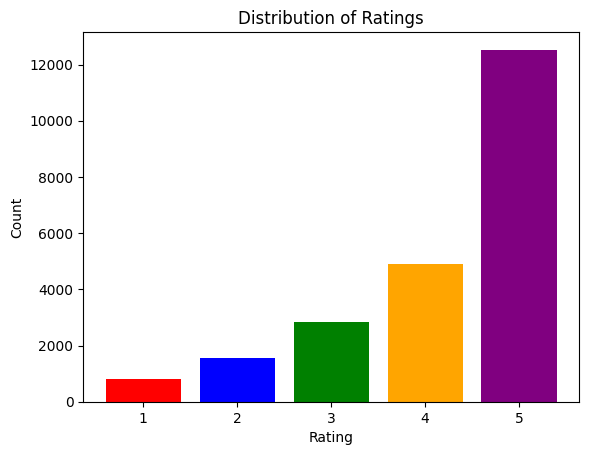

In [3]:


# Defining the x and y values
x = [1, 2, 3, 4, 5]
y = [821, 1549, 2823, 4908, 12527]

# Creating a bar chart of the ratings data
plt.bar(x, y)

# Defining the colors for the bars
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Creating a bar chart with different colors
plt.bar(x, y, color=colors)


# Setting the chart title and axis labels
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Displaying the chart
plt.show()

# Model Imbalance

In [4]:
df.head()
df.shape

X_text = df['Review Text']  # Text data```
y = df['Sentiment']  # Target variable

In [5]:
# Convert sentiment labels to 2, 1, 0
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
y = y.map(label_mapping)

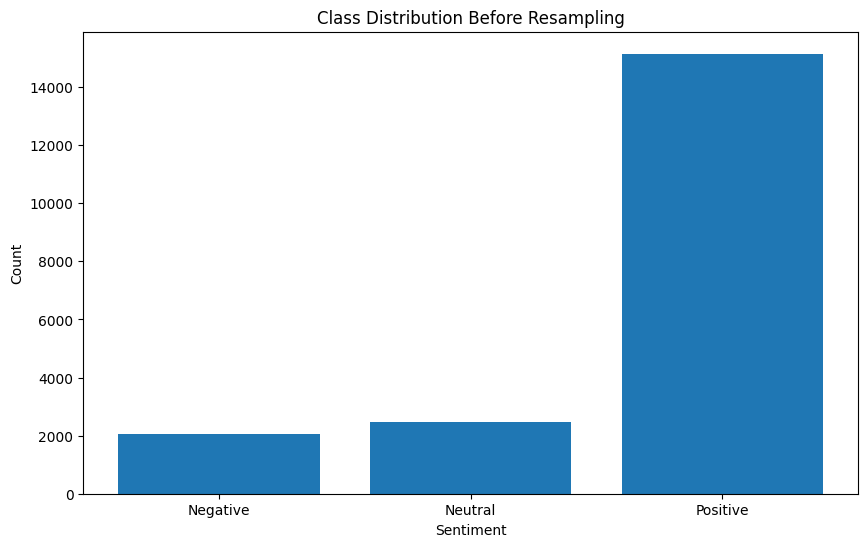

In [6]:
# Visualize the class distribution before resampling
plt.figure(figsize=(10, 6))
plt.bar(Counter(y).keys(), Counter(y).values())
plt.title('Class Distribution Before Resampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.show()

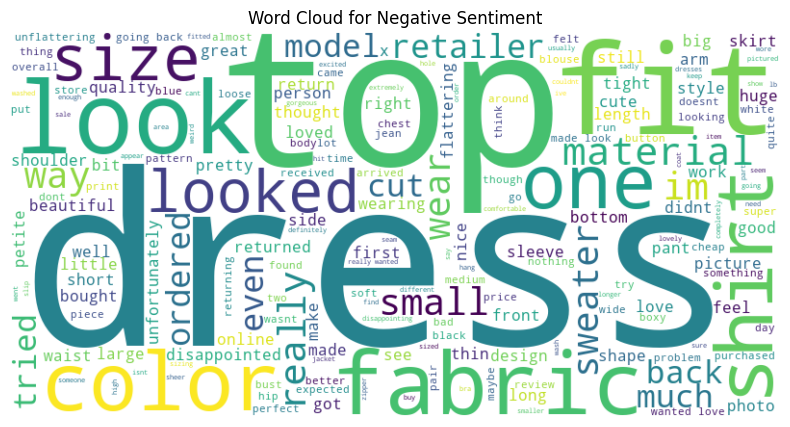

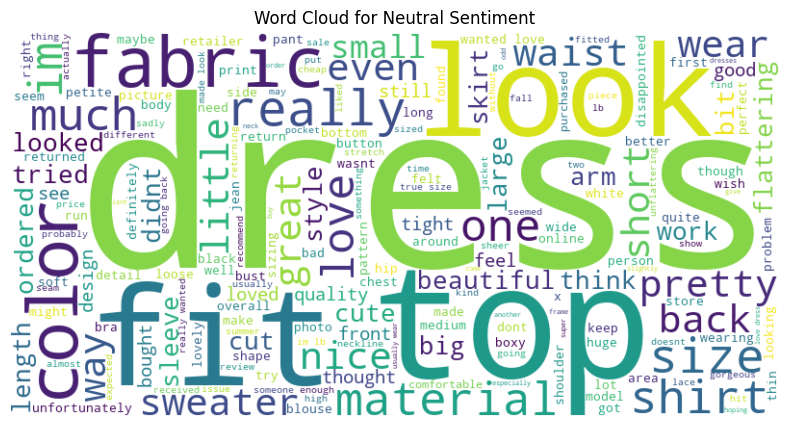

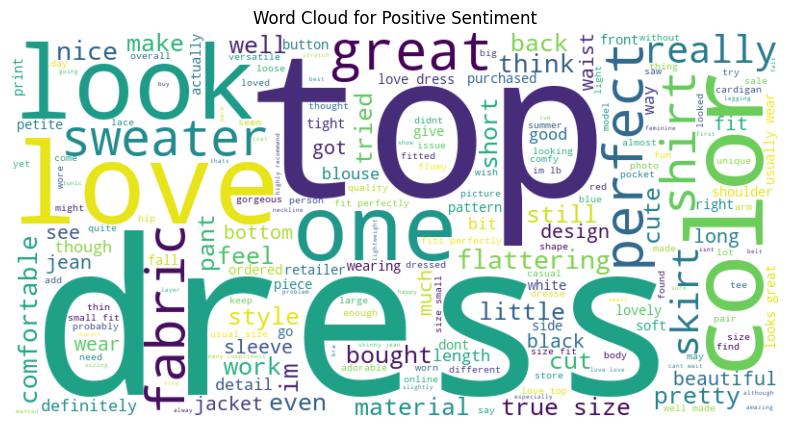

In [7]:
# Create word clouds for each sentiment label
sentiments = ['negative', 'neutral', 'positive']

for sentiment in sentiments:
    # Filter texts by sentiment
    texts = df[df['Sentiment'] == sentiment]['Review Text'].tolist()
    text = ' '.join(texts)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.axis('off')
    plt.show()

In [8]:
df = df.sample(frac=.1, random_state=42).reset_index(drop=True)

In [9]:
# Smaller set for testing
TRAIN_TEST_SPLIT = 0.2
SAMPLE_SIZE = int(df.groupby('Sentiment').size().min() * (1 - TRAIN_TEST_SPLIT))
SAMPLE_SIZE
over_sampling_strategy = {0: SAMPLE_SIZE, 1: SAMPLE_SIZE, 2: SAMPLE_SIZE}
under_sampling_strategy = {0: SAMPLE_SIZE, 1: SAMPLE_SIZE, 2: SAMPLE_SIZE}


In [10]:
# Define the resampling techniques
# Define the resampling techniques
# over_sampling_strategy = {2: 17435, 1: 17435, 0: 17435}
# under_sampling_strategy = {2: 17435, 1: 17435, 0: 17435}

# cur
over_sampler = SMOTE(sampling_strategy=over_sampling_strategy)
under_sampler = RandomUnderSampler(sampling_strategy=under_sampling_strategy)

In [11]:
# Define the pipeline for TF-IDF transformation
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text data to TF-IDF features
])

# Apply TF-IDF transformation
X_tfidf = tfidf_pipeline.fit_transform(X_text)

# Define the pipeline for resampling
resampling_pipeline = Pipeline([
    # ('o', over_sampler),  # Oversample minority classes
    ('u', under_sampler)  # Undersample majority classes
])

In [12]:
# Apply resampling
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_tfidf, y)

In [13]:
# Print the output of each step in the pipeline
print("Output after TF-IDF transformation:")
print(X_resampled)

Output after TF-IDF transformation:
  (0, 16352)	0.38030033182332623
  (0, 14734)	0.31522080420232873
  (0, 8808)	0.2939972182782558
  (0, 10784)	0.2711745312296309
  (0, 7064)	0.2503770371638071
  (0, 9360)	0.16222518844911182
  (0, 12139)	0.2526593425347946
  (0, 16533)	0.18027380091385567
  (0, 8434)	0.15965159526644823
  (0, 5071)	0.13585230347498245
  (0, 8229)	0.23861920992529578
  (0, 9989)	0.15054651517826592
  (0, 9780)	0.26923512346038037
  (0, 8514)	0.10780164572344855
  (0, 15445)	0.3726470576589233
  (0, 16443)	0.20699248882862092
  (0, 11712)	0.14604151790097356
  (1, 2710)	0.3696641634285286
  (1, 8580)	0.3804734577346901
  (1, 13160)	0.29626374714152376
  (1, 7211)	0.40073220112505314
  (1, 17186)	0.3126076728133782
  (1, 6685)	0.2756667251347865
  (1, 11656)	0.2355507025040153
  (1, 15134)	0.18551288422516662
  :	:
  (499, 5424)	0.15588417351912912
  (499, 13270)	0.21393874032610477
  (499, 8229)	0.2357327998497949
  (499, 16159)	0.17215966678069608
  (499, 16648)	0.15

In [14]:
# Check the class distribution after resampling
print("Class distribution after resampling:", Counter(y_resampled))

Class distribution after resampling: Counter({0: 167, 1: 167, 2: 167})


In [15]:
# Convert X_resampled and y_resampled to DataFrame
balanced_df = pd.DataFrame({'Review Text': X_resampled, 'Sentiment': y_resampled})

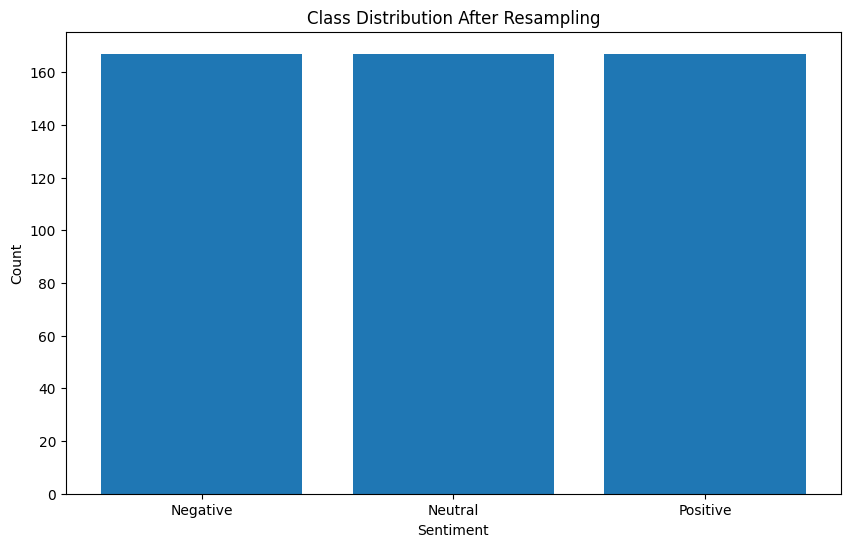

,Review Text,Sentiment
0,"(0, 16352)\t0.38030033182332623\n (0, 14734...",0
1,"(0, 2710)\t0.3696641634285286\n (0, 8580)\t...",0
2,"(0, 13955)\t0.21840454352533736\n (0, 6876)...",0
3,"(0, 5033)\t0.36468899250511255\n (0, 8808)\...",0
4,"(0, 12805)\t0.4487678923710029\n (0, 10163)...",0
...,...,...
496,"(0, 5655)\t0.23490648721535054\n (0, 552)\t...",2
497,"(0, 2467)\t0.4016016280683455\n (0, 4868)\t...",2
498,"(0, 13925)\t0.5109626737362655\n (0, 12503)...",2
499,"(0, 2046)\t0.4487435109587972\n (0, 7618)\t...",2


In [16]:
# Visualize the class distribution after resampling
plt.figure(figsize=(10, 6))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title('Class Distribution After Resampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'])
plt.show()

# Save the balanced dataset as df
# balanced_df.to_csv(/.kaggle/working/womenclothing/balanced_dataset.csv', index=False)
balanced_df

In [17]:
from scipy.sparse import csr_matrix

In [18]:
# Get the trained TfidfVectorizer from your TF-IDF pipeline
tfidf_vectorizer = tfidf_pipeline.named_steps['tfidf']

# Convert the TF-IDF transformed data back to the original text format
X_text_original = tfidf_vectorizer.inverse_transform(X_resampled)

# Create a new DataFrame with the original text format
df_original = pd.DataFrame({'Review Text': [' '.join(row) for row in X_text_original], 'Sentiment': y_resampled})

# Perform Train Test Split (or Train, Test, Validation Split)

In [28]:
X, y = df_original['Review Text'], df_original['Sentiment']


X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Save Data before Modeling

In [29]:
OUTPUT_PATH = '../data/train_test_val/'
X_train.to_csv(os.path.join(OUTPUT_PATH, 'X_train.csv'), index=False)
X_val.to_csv(os.path.join(OUTPUT_PATH, 'X_val.csv'), index=False)
X_test.to_csv(os.path.join(OUTPUT_PATH, 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(OUTPUT_PATH, 'y_train.csv'), index=False)
y_val.to_csv(os.path.join(OUTPUT_PATH, 'y_val.csv'), index=False)
y_test.to_csv(os.path.join(OUTPUT_PATH, 'y_test.csv'), index=False)
